In [5]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import os
import fiftyone as fo
import shutil
import pandas as pd
import cv2
import random
import hashlib
from PIL import Image
import albumentations as A
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from transformers import TFSegformerForSemanticSegmentation
from transformers import create_optimizer
import torch
import numpy as np
from diffusers.utils import load_image, make_image_grid
import torch
from torchvision.transforms.functional import to_pil_image
from PIL import Image
import cv2
from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import copy
from diffusers import StableDiffusionInpaintPipeline, EulerDiscreteScheduler

In [3]:
df=pd.read_csv("labels.csv")

In [4]:
id2label = {}
for i,j in df.iterrows():
  if i==0:
    id2label[i] = 'nan'
  else:
    id2label[i] = j['label_list']
label2id = {label: id for id,label in id2label.items()}
print(label2id)
print(len(label2id))

{'nan': 0, 'accessories': 1, 'bag': 2, 'belt': 3, 'blazer': 4, 'blouse': 5, 'bodysuit': 6, 'boots': 7, 'bra': 8, 'bracelet': 9, 'cape': 10, 'cardigan': 11, 'clogs': 12, 'coat': 13, 'dress': 14, 'earrings': 15, 'flats': 16, 'glasses': 17, 'gloves': 18, 'hair': 19, 'hat': 20, 'heels': 21, 'hoodie': 22, 'intimate': 23, 'jacket': 24, 'jeans': 25, 'jumper': 26, 'leggings': 27, 'loafers': 28, 'necklace': 29, 'panties': 30, 'pants': 31, 'pumps': 32, 'purse': 33, 'ring': 34, 'romper': 35, 'sandals': 36, 'scarf': 37, 'shirt': 38, 'shoes': 39, 'shorts': 40, 'skin': 41, 'skirt': 42, 'sneakers': 43, 'socks': 44, 'stockings': 45, 'suit': 46, 'sunglasses': 47, 'sweater': 48, 'sweatshirt': 49, 'swimwear': 50, 't-shirt': 51, 'tie': 52, 'tights': 53, 'top': 54, 'vest': 55, 'wallet': 56, 'watch': 57, 'wedges': 58}
59


In [14]:
im_path = "//png_images//IMAGES//"
anno_path = "//png_masks//MASKS//"
val_im_path ="//val_dataset//png_masks//IMAGES//"
val_anno_path = "//val_dataset//png_masks//MASKS//"
'''os.makedirs(val_im_path)
os.makedirs(val_anno_path)'''

'os.makedirs(val_im_path)\nos.makedirs(val_anno_path)'

In [43]:
for fname in os.listdir(anno_path):
  os.rename(anno_path+fname,anno_path+"img"+fname[3:])

In [16]:
val_list=["0115","0025","0010","0003","0125","0200","0515","0225","0805","0915","0630","0301","0112","0905","0823","0527","0088","0055","0018",
          "0222","0049","0273","0299","0282","0372","0027","0445","0582","0374","0956","0211","0019","0961","0397","0699","0789","0996","0290",
          "0110","0315","0335","0419","0666","0525","0927","0555","0275","0855","0815","0130","0371","0412","0105","0423","0507","0028","0035","0118",
          "0232","0849","0673","0688","0777","0472","0991","0485","0592","0334","0827","0651","0619","0567","0393","0609","0719","0916","0190",
          ]

In [17]:
import shutil

In [18]:
for name in val_list:
  shutil.move(im_path+"img_"+name+".png", val_im_path+"img_"+name+".png")
  shutil.move(anno_path+"img_"+name+".png", val_anno_path+"img_"+name+".png")

In [19]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    ([im_path+i for i in os.listdir(im_path)],
    [anno_path+"img"+i[3:] for i in os.listdir(im_path)])
)
val_dataset = tf.data.Dataset.from_tensor_slices(
    ([val_im_path+i for i in os.listdir(val_im_path)],
    [val_anno_path+"img"+i[3:] for i in os.listdir(val_im_path)])
)

In [20]:
for i in train_dataset.take(3):
  print(i)

(<tf.Tensor: shape=(), dtype=string, numpy=b'C://Users//Avantika//Downloads//image aneration//png_images//IMAGES//img_0001.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'C://Users//Avantika//Downloads//image aneration//png_masks//MASKS//img_0001.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'C://Users//Avantika//Downloads//image aneration//png_images//IMAGES//img_0002.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'C://Users//Avantika//Downloads//image aneration//png_masks//MASKS//img_0002.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'C://Users//Avantika//Downloads//image aneration//png_images//IMAGES//img_0004.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'C://Users//Avantika//Downloads//image aneration//png_masks//MASKS//img_0004.png'>)


In [21]:
def preprocess(im_path, anno_path):
  img = tf.io.decode_jpeg(tf.io.read_file(im_path))
  img = tf.cast(img,tf.float32)
  img = (img-MEAN)/STD#normalizing

  anno = tf.io.decode_jpeg(tf.io.read_file(anno_path))
  anno = tf.cast(tf.squeeze(anno,-1),tf.float32)

  return img, anno

In [23]:
MEAN = [123.675, 116.28, 103.53]
STD = [58.395, 57.12, 57.375]


In [24]:
prep_train_ds = (
    train_dataset
    .map(preprocess,num_parallel_calls=tf.data.AUTOTUNE)
)
prep_val_ds = (
    val_dataset
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
)

In [25]:
for i,j in prep_train_ds.take(1):
  print(i.shape,j.shape)

(825, 550, 3) (825, 550)


In [26]:
H,W = 512,512

In [27]:
transform = A.Compose([
    A.RandomCrop (H,W, p=1.0),
    A.HorizontalFlip(p=0.3),
    A.VerticalFlip(p=0.3),
    A.RandomRotate90(p=0.3),
    A.Transpose(p=0.3),
    A.Sharpen (alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=0.1),
    A.RandomShadow (shadow_roi=(0, 0.5, 1, 1),
                    num_shadows_lower=1, num_shadows_upper=2,
                    shadow_dimension=5, p=0.1),
    A.RandomBrightnessContrast(p=0.2),
    #A.Resize(H,W),
])

val_transform = A.Compose([
    A.Resize(H,W),
])

In [28]:
def aug_albument(image,mask):
  augmented = transform(image=image, mask=mask)
  return [tf.convert_to_tensor(augmented["image"],dtype=tf.float32),
          tf.convert_to_tensor(augmented["mask"], dtype=tf.float32)]
def val_aug_albument(image,mask):
  augmented = val_transform(image=image, mask=mask)
  return [tf.convert_to_tensor(augmented["image"],dtype=tf.float32),
          tf.convert_to_tensor(augmented["mask"], dtype=tf.float32)]

In [29]:
def augment(image,mask):
  aug_output = tf.numpy_function(func=aug_albument, inp=[image,mask], Tout=[tf.float32,tf.float32])
  return {"pixel_values":tf.transpose(aug_output[0],(2,0,1)), "labels":aug_output[1]}

def val_augment(image,mask):
  aug_output = tf.numpy_function(func=val_aug_albument, inp=[image,mask], Tout=[tf.float32,tf.float32])
  return {"pixel_values":tf.transpose(aug_output[0],(2,0,1)), "labels":aug_output[1]}

In [30]:
BATCH_SIZE = 2
train_ds = (
    prep_train_ds
    .shuffle(10)
    .map(augment,num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
val_ds = (
    prep_val_ds
    .map(val_augment,num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [31]:
for i in train_ds.take(1):
  data = i

  print(i)

{'pixel_values': <tf.Tensor: shape=(2, 3, 512, 512), dtype=float32, numpy=
array([[[[ 2.0091617 ,  2.0091617 ,  2.0091617 , ..., -0.08005828,
          -0.08005828, -0.08005828],
         [ 2.0262864 ,  2.0262864 ,  2.0262864 , ...,  0.02269025,
           0.02269025,  0.05693975],
         [ 2.0262864 ,  2.0262864 ,  2.0262864 , ...,  0.07406451,
           0.07406451,  0.07406451],
         ...,
         [ 2.0262864 ,  2.0262864 ,  2.0262864 , ..., -0.6280504 ,
          -0.6280504 , -0.6280504 ],
         [ 2.0262864 ,  2.0262864 ,  2.0262864 , ..., -0.6280504 ,
          -0.6280504 , -0.6280504 ],
         [ 2.0262864 ,  2.0262864 ,  2.0262864 , ..., -0.6109256 ,
          -0.6109256 , -0.6109256 ]],

        [[ 2.1309524 ,  2.1309524 ,  2.1309524 , ..., -0.09243695,
          -0.07492995, -0.09243695],
         [ 2.1484594 ,  2.1484594 ,  2.1484594 , ...,  0.11764708,
           0.11764708,  0.10014008],
         [ 2.1484594 ,  2.1484594 ,  2.1484594 , ...,  0.2051821 ,
          

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


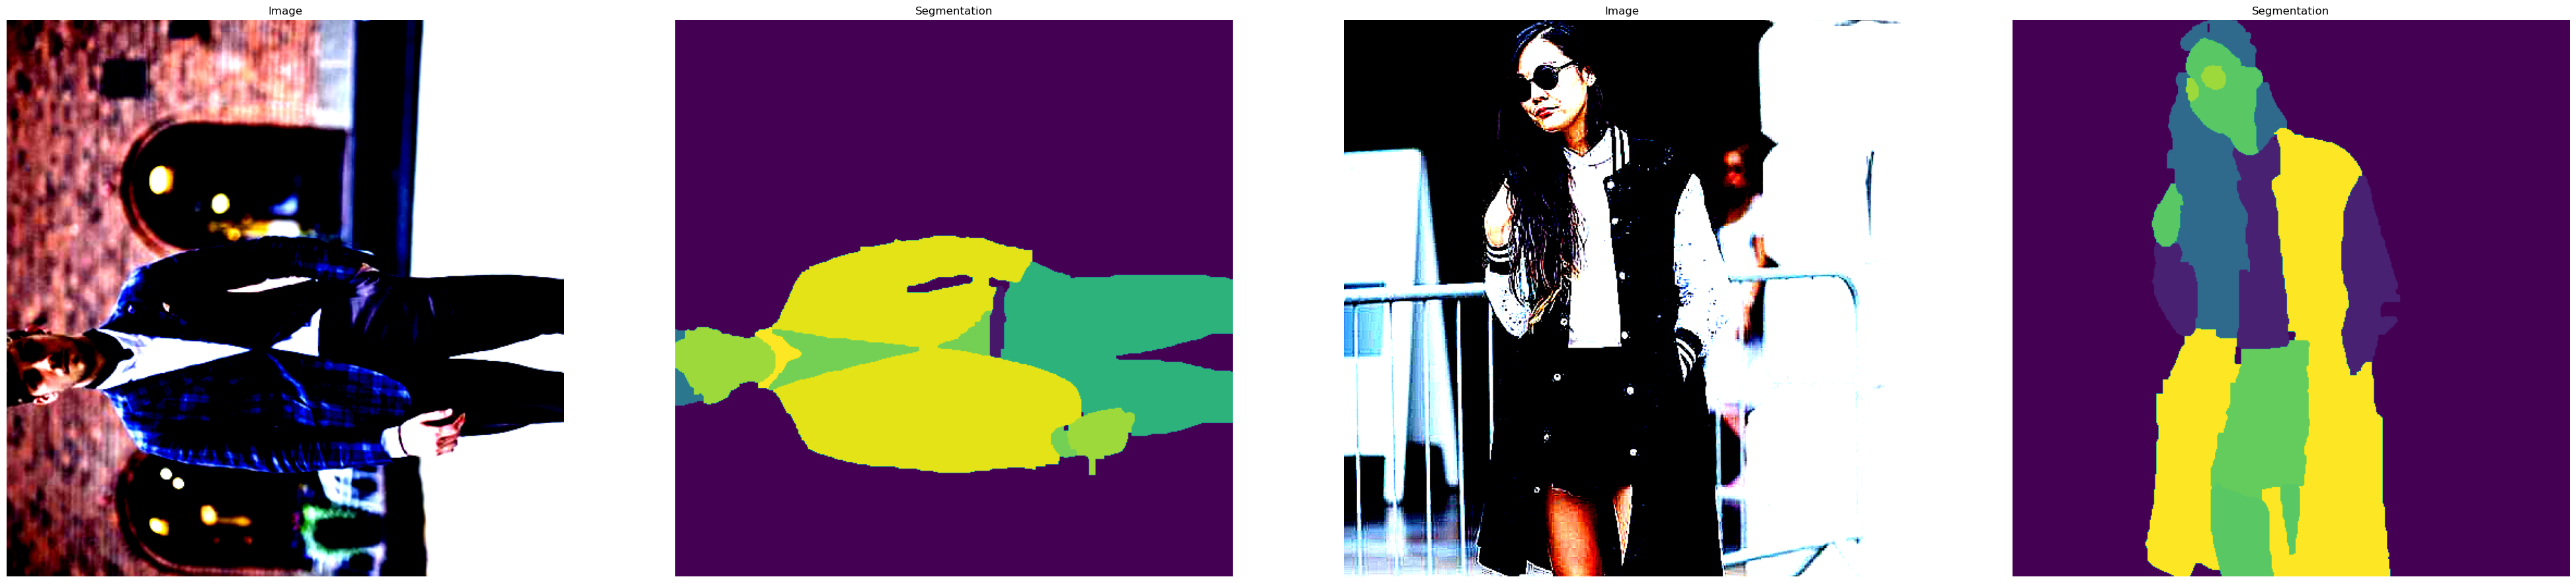

In [32]:
plt.figure(figsize = (50,50))

for data in train_ds.take(1):
  images=data['pixel_values']
  labels=data['labels']
  for i in range(BATCH_SIZE*2):
    if i==4:
      break
    ax = plt.subplot(1,BATCH_SIZE*2, i+1)
    if i%2==0:
      plt.imshow(tf.transpose(images[i//2], (1, 2, 0)))
      plt.title("Image")
    else:
      plt.imshow(labels[i//2])
      plt.title("Segmentation")
    plt.axis("off")
  plt.show()

In [46]:
name="clothing-dataset-3"
data_path="//val_dataset//png_images//IMAGES"
labels_path="//val_dataset//png_masks//MASKS"

In [50]:
for fname in os.listdir(anno_path):
  os.rename(anno_path+fname,anno_path+"img"+fname[3:])

In [53]:
#create the dataset
name="clothing-dataset-4"
data_path="//val_dataset//png_images//IMAGES"
labels_path="//val_dataset//png_masks//MASKS"

dataset=fo.Dataset.from_dir(
    data_path=data_path,
    labels_path=labels_path,
    dataset_type=fo.types.ImageSegmentationDirectory,
    name=name,)

print(dataset)
print(dataset.head)
    

 100% |███████████████████| 77/77 [171.7ms elapsed, 0s remaining, 467.7 samples/s] 
Name:        clothing-dataset-4
Media type:  image
Num samples: 77
Persistent:  False
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Segmentation)
<bound method Dataset.head of Name:        clothing-dataset-4
Media type:  image
Num samples: 77
Persistent:  False
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata

In [54]:
session = fo.launch_app(dataset)


Welcome to

███████╗██╗███████╗████████╗██╗   ██╗ ██████╗ ███╗   ██╗███████╗
██╔════╝██║██╔════╝╚══██╔══╝╚██╗ ██╔╝██╔═══██╗████╗  ██║██╔════╝
█████╗  ██║█████╗     ██║    ╚████╔╝ ██║   ██║██╔██╗ ██║█████╗
██╔══╝  ██║██╔══╝     ██║     ╚██╔╝  ██║   ██║██║╚██╗██║██╔══╝
██║     ██║██║        ██║      ██║   ╚██████╔╝██║ ╚████║███████╗
╚═╝     ╚═╝╚═╝        ╚═╝      ╚═╝    ╚═════╝ ╚═╝  ╚═══╝╚══════╝ v0.23.0rc1

If you're finding FiftyOne helpful, here's how you can get involved:

|
|  ⭐⭐⭐ Give the project a star on GitHub ⭐⭐⭐
|  https://github.com/voxel51/fiftyone
|
|  🚀🚀🚀 Join the FiftyOne Slack community 🚀🚀🚀
|  https://slack.voxel51.com
|


Could not connect session, trying again in 10 seconds



In [59]:
id2label={}
for i,j in df.iterrows():
    if i==0 :
        id2label[i]="nan"
    else:
        id2label[i]=j['label_list']

In [60]:
id2label

{0: 'nan',
 1: 'accessories',
 2: 'bag',
 3: 'belt',
 4: 'blazer',
 5: 'blouse',
 6: 'bodysuit',
 7: 'boots',
 8: 'bra',
 9: 'bracelet',
 10: 'cape',
 11: 'cardigan',
 12: 'clogs',
 13: 'coat',
 14: 'dress',
 15: 'earrings',
 16: 'flats',
 17: 'glasses',
 18: 'gloves',
 19: 'hair',
 20: 'hat',
 21: 'heels',
 22: 'hoodie',
 23: 'intimate',
 24: 'jacket',
 25: 'jeans',
 26: 'jumper',
 27: 'leggings',
 28: 'loafers',
 29: 'necklace',
 30: 'panties',
 31: 'pants',
 32: 'pumps',
 33: 'purse',
 34: 'ring',
 35: 'romper',
 36: 'sandals',
 37: 'scarf',
 38: 'shirt',
 39: 'shoes',
 40: 'shorts',
 41: 'skin',
 42: 'skirt',
 43: 'sneakers',
 44: 'socks',
 45: 'stockings',
 46: 'suit',
 47: 'sunglasses',
 48: 'sweater',
 49: 'sweatshirt',
 50: 'swimwear',
 51: 't-shirt',
 52: 'tie',
 53: 'tights',
 54: 'top',
 55: 'vest',
 56: 'wallet',
 57: 'watch',
 58: 'wedges'}

In [63]:
label2id={label:id for id,label in id2label.items()}

In [64]:
print(label2id)

{'nan': 0, 'accessories': 1, 'bag': 2, 'belt': 3, 'blazer': 4, 'blouse': 5, 'bodysuit': 6, 'boots': 7, 'bra': 8, 'bracelet': 9, 'cape': 10, 'cardigan': 11, 'clogs': 12, 'coat': 13, 'dress': 14, 'earrings': 15, 'flats': 16, 'glasses': 17, 'gloves': 18, 'hair': 19, 'hat': 20, 'heels': 21, 'hoodie': 22, 'intimate': 23, 'jacket': 24, 'jeans': 25, 'jumper': 26, 'leggings': 27, 'loafers': 28, 'necklace': 29, 'panties': 30, 'pants': 31, 'pumps': 32, 'purse': 33, 'ring': 34, 'romper': 35, 'sandals': 36, 'scarf': 37, 'shirt': 38, 'shoes': 39, 'shorts': 40, 'skin': 41, 'skirt': 42, 'sneakers': 43, 'socks': 44, 'stockings': 45, 'suit': 46, 'sunglasses': 47, 'sweater': 48, 'sweatshirt': 49, 'swimwear': 50, 't-shirt': 51, 'tie': 52, 'tights': 53, 'top': 54, 'vest': 55, 'wallet': 56, 'watch': 57, 'wedges': 58}


In [85]:
model_checkpoint = "nvidia/segformer-b5-finetuned-cityscapes-1024-1024"
model_id="nvidia/segformer-b0-finetuned-ade-512-512"

In [82]:
!pip install transformers


In [83]:
from transformers import AutoImageProcessor, TFSegformerForSemanticSegmentation


In [86]:
model = TFSegformerForSemanticSegmentation.from_pretrained(
    model_id,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

                                                          


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFSegformerForSemanticSegmentation: ['decode_head.classifier.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.classifier.weight']
- This IS expected if you are initializing TFSegformerForSemanticSegmentation from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFSegformerForSemanticSegmentation from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFSegformerForSemanticSegmentation were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFSegformerForSemanticSegmentation for predictions without further training.
Some w

In [87]:
model.summary()

Model: "tf_segformer_for_semantic_segmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 segformer (TFSegformerMain  multiple                  3319392   
 Layer)                                                          
                                                                 
 decode_head (TFSegformerDe  multiple                  410427    
 codeHead)                                                       
                                                                 
Total params: 3729819 (14.23 MB)
Trainable params: 3729307 (14.23 MB)
Non-trainable params: 512 (2.00 KB)
_________________________________________________________________


In [88]:
model(tf.zeros([1,3,H,W])).logits.shape

TensorShape([1, 59, 128, 128])

In [90]:
batch_size = 2
num_epochs = 15
num_train_steps = len(train_ds) * num_epochs
learning_rate = 6e-5
weight_decay_rate = 0.01

optimizer, lr_schedule = create_optimizer(
    init_lr=learning_rate,
    num_train_steps=num_train_steps,
    weight_decay_rate=weight_decay_rate,
    num_warmup_steps=0,
)

In [91]:
model.compile(optimizer=optimizer)

In [93]:
import evaluate
metric = evaluate.load("mean_iou")

In [94]:
model(tf.zeros([1,3,H,W])).logits.shape

TensorShape([1, 59, 128, 128])

In [95]:
def compute_metrics(eval_pred):
  logits, labels = eval_pred
  logits = tf.transpose(logits, perm=[0,2,3,1])
  logits_resized =tf.image.resize(
      logits,
      size=tf.shape(labels)[1:],
      method="bilinear"
  )
  pred_labels = tf.argmax(logits_resized, axis=-1)

  metrics = metric.compute(
      predictions = pred_labels,
      references = labels,
      num_labels = len(label2id),
      ignore_index = 0,
  )

  per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
  per_category_iou = metrics.pop("per_category_iou").tolist()

  metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
  metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})

  return {"val_" + k: v for k, v in metrics.items()}

In [96]:
from transformers.keras_callbacks import KerasMetricCallback

metric_callback = KerasMetricCallback(
    metric_fn=compute_metrics,
    eval_dataset=val_ds,
    batch_size=batch_size,
    label_cols=["labels"]
)
callbacks = [metric_callback]

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=num_epochs,
    callbacks=callbacks,
)

Epoch 1/15

462/462 [==============================] - ETA: 0s - loss: 1.7599

C:\Users\Avantika\anaconda3\Lib\site-packages\datasets\features\image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
C:\Users\Avantika\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\Avantika\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


462/462 [==============================] - 4096s 9s/step - loss: 1.7599 - val_loss: 0.9245 - val_mean_iou: 0.0204 - val_mean_accuracy: 0.0482 - val_overall_accuracy: 0.2807 - val_accuracy_nan: nan - val_accuracy_accessories: 0.0000e+00 - val_accuracy_bag: 0.0179 - val_accuracy_belt: 0.0000e+00 - val_accuracy_blazer: 0.0000e+00 - val_accuracy_blouse: 0.0000e+00 - val_accuracy_bodysuit: 0.0000e+00 - val_accuracy_boots: 0.0000e+00 - val_accuracy_bra: nan - val_accuracy_bracelet: 0.0000e+00 - val_accuracy_cape: 0.0000e+00 - val_accuracy_cardigan: 0.0000e+00 - val_accuracy_clogs: nan - val_accuracy_coat: 0.5132 - val_accuracy_dress: 0.5179 - val_accuracy_earrings: nan - val_accuracy_flats: 0.0000e+00 - val_accuracy_glasses: 0.0000e+00 - val_accuracy_gloves: 0.0000e+00 - val_accuracy_hair: 0.0204 - val_accuracy_hat: 0.0000e+00 - val_accuracy_heels: 0.0000e+00 - val_accuracy_hoodie: nan - val_accuracy_intimate: nan - val_accuracy_jacket: 0.0000e+00 - val_accuracy_jeans: 0.0124 - val_accuracy_

In [ ]:
H_resized, W_resized = 512,512
H_init, W_init = 825,550


In [ ]:
for i,sample in enumerate(dataset):

  img = tf.io.decode_jpeg(tf.io.read_file(sample.filepath))
  img = tf.image.resize(img, (H_resized, W_resized))
  img = tf.cast(img,tf.float32)
  img = (img-MEAN)/STD
  img = tf.transpose(img, (2,0,1))
  img = tf.expand_dims(img, axis=0)

  output = model(img).logits
  output = tf.argmax(output, axis=1)

  resized_output = tf.image.resize(
      tf.expand_dims(output,axis=-1),(H_init, W_init), method="bilinear", antialias=True)
  resized_output = tf.cast(tf.squeeze(resized_output, axis=-1),dtype=tf.uint8)[0]
  sample["pred"] = fo.Segmentation(mask=resized_output.numpy())

  mask = cv2.imread(sample["ground_truth"]["mask_path"], cv2.IMREAD_GRAYSCALE)
  metrics = metric.compute(
      predictions = [resized_output.numpy()],
      references = [mask],
      num_labels = len(label2id),
      ignore_index = 0,
      nan_to_num=0,
      reduce_labels=False
  )


  sample["mean_iou"] = metrics["mean_iou"]
  sample["mean_accuracy"] = metrics["mean_accuracy"]
  sample["overall_accuracy"] = metrics["overall_accuracy"]

  for k,c in enumerate(metrics["per_category_iou"]):
    if c>0.0001:
      key = id2label[k]+"_iou"### e.g. shoes_iou
      sample[key] = c

  sample.save()

In [ ]:
model(tf.ones([1,3,512,512])).logits.shape

In [ ]:
dataset.default_mask_targets = id2label
session = fo.launch_app(dataset,port=51)

In [ ]:
def generate_inputs(im_path, mask_label):
  mask_id = label2id[mask_label]
  source_image = cv2.imread(im_path)

  img = tf.io.decode_jpeg(tf.io.read_file(im_path))
  img = tf.image.resize(img, (H_resized, W_resized))
  img = tf.cast(img, tf.float32)
  img = (img-MEAN)/STD
  img = tf.transpose(img, (2,0,1))
  img = tf.expand_dims(img, axis=0)

  output = model(img).logits

  output = tf.argmax(output, axis=1)

  resized_output = tf.image.resize(
      tf.expand_dims(output,axis=-1),(H_init, W_init), method="bilinear", antialias=True)
  resized_output = tf.cast(tf.squeeze(resized_output, axis=-1),dtype=tf.uint8)[0].numpy()
  mask = resized_output+(-mask_id*np.ones_like(resized_output))

  mask = 255-np.clip(1e10*np.multiply(mask,mask),a_min=0, a_max=255)
  cv2.imwrite("mask.jpg", mask)

  return Image.fromarray(source_image), Image.fromarray(mask)

In [ ]:
generate_inputs("img_0003.png","coat")

In [ ]:
from diffusers import StableDiffusionInpaintPipeline
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
)
pipe.to("cuda")
pipe.enable_xformers_memory_efficient_attention()

In [ ]:
prompt = "A photorealistic photo of a woman wearing a green-colored nice looking coat all green high resolution"
#image and mask_image should be PIL images.
#The mask structure is white for inpainting and black for keeping as is
image, mask_image = generate_inputs(
    "img_0003.png","coat")

image = pipe(prompt=prompt, image=image, mask_image=mask_image, ).images[0]
image.resize((W_init, H_init))
display(image.resize((550,825)))

In [ ]:
checkpoint_filepath="path to directory"

model.save_weights(checkpoint_filepath,save_format='h5')